# Project: Energy Consumption Forecasting Using Time Series  
This notebook provides a step-by-step guide for solving the problem of energy consumption forecasting using time series analysis.  
We will use the **PJM Hourly Energy Consumption** dataset, available on **Kaggle**: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
import scipy.stats as stats
from scipy.stats import shapiro
import statsmodels.api as sm
from statsmodels.formula.api import ols

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from datetime import datetime, timedelta

from joblib import Parallel, delayed
import itertools
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import  mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

import time


from prophet import Prophet
from matplotlib.ticker import FuncFormatter

In [3]:
# Dickey-Fuller Test Function with ACF and PACF
def Dickey_Fuller_test_with_acf_pacf_sns(data: pd.Series):
    """
    Extended Dickey-Fuller test for time series stationarity.
    
    Args:
        data (pd.Series): time series data
        
    Returns:
        data (pd.Series): differenced data
        diff_order (int): order of differencing
    """
    diff_order = 0  # Initial differencing order
    
    while True:
        test_result = adfuller(data)
        
        if test_result[0] > test_result[4]['5%']:
            data = data.diff().dropna()  # Apply differencing
            diff_order += 1
            print(f'Attempt {diff_order}: the series is non-stationary')
        else:
            print("ADF Statistic: {:.2f}".format(test_result[0]))
            print("p-value: {:.2g}".format(test_result[1]))
            print("Critical Values:")
            for key, value in test_result[4].items():
                print(f"\t{key}: {value:.3f}")
            print(f'The series is stationary\nOrder of differencing = {diff_order}')
            break
        
    return data, diff_order


# Data Loading and Initial Analysis

In [4]:
pjme_df = pd.read_csv('data/hourly-energy-consumption/PJME_hourly.csv')

In [5]:
# Convert the time column to datetime format
pjme_df['Datetime'] = pd.to_datetime(pjme_df['Datetime'])

In [6]:
pjme_df.describe()

,Datetime,PJME_MW
count,145366,145366.000000
mean,2010-04-18 03:25:25.999202048,32080.222831
min,2002-01-01 01:00:00,14544.000000
25%,2006-02-23 14:15:00,27573.000000
50%,2010-04-18 04:30:00,31421.000000
75%,2014-06-10 18:45:00,35650.000000
max,2018-08-03 00:00:00,62009.000000
std,NaN,6464.012166


In [7]:
pjme_df.isnull().sum()

Datetime    0
PJME_MW     0
dtype: int64

In [8]:
pjme_df.duplicated().sum()

0

### Checking Time Intervals:

In [9]:
# Identifying missing time stamps
all_dates = pd.date_range(start=pjme_df['Datetime'].min(), end=pjme_df['Datetime'].max(), freq='H')
missing_dates = all_dates.difference(pjme_df['Datetime'])
print(f"Missing time stamps: {len(missing_dates)}")


Missing time stamps: 30


C:\Users\mazur\AppData\Local\Temp\ipykernel_30060\2417508613.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  all_dates = pd.date_range(start=pjme_df['Datetime'].min(), end=pjme_df['Datetime'].max(), freq='H')


In [10]:
# Convert the 'Datetime' column to an index for comparison
actual_dates = pd.DatetimeIndex(pjme_df['Datetime'])

# Find missing dates
missing_dates = all_dates.difference(actual_dates)

# Print the number of missing time stamps and the missing dates themselves
print(f"Number of missing time stamps: {len(missing_dates)}")
print(f"Missing time stamps: {missing_dates}")


Number of missing time stamps: 30
Missing time stamps: DatetimeIndex(['2002-04-07 03:00:00', '2002-10-27 02:00:00',
               '2003-04-06 03:00:00', '2003-10-26 02:00:00',
               '2004-04-04 03:00:00', '2004-10-31 02:00:00',
               '2005-04-03 03:00:00', '2005-10-30 02:00:00',
               '2006-04-02 03:00:00', '2006-10-29 02:00:00',
               '2007-03-11 03:00:00', '2007-11-04 02:00:00',
               '2008-03-09 03:00:00', '2008-11-02 02:00:00',
               '2009-03-08 03:00:00', '2009-11-01 02:00:00',
               '2010-03-14 03:00:00', '2010-11-07 02:00:00',
               '2010-12-10 00:00:00', '2011-03-13 03:00:00',
               '2011-11-06 02:00:00', '2012-03-11 03:00:00',
               '2012-11-04 02:00:00', '2013-03-10 03:00:00',
               '2013-11-03 02:00:00', '2014-03-09 03:00:00',
               '2015-03-08 03:00:00', '2016-03-13 03:00:00',
               '2017-03-12 03:00:00', '2018-03-11 03:00:00'],
              dtype='datetime

The list of missing time stamps indicates that many of them coincide with the transitions to and from daylight saving time. Gaps in time series data often occur during these transitions because an hour is "lost" when switching to daylight saving time (e.g., at 03:00) and can be "duplicated" when switching back to standard time (e.g., at 02:00).

Since these gaps are related to daylight saving time transitions and are recurring seasonal events, they can be left as is. This is a natural aspect of time series data, especially when dealing with energy consumption time series.


# Data Analysis and Visualization (EDA)

## Data Visualization

#### Energy Consumption Time Series: Let's plot energy consumption over time.

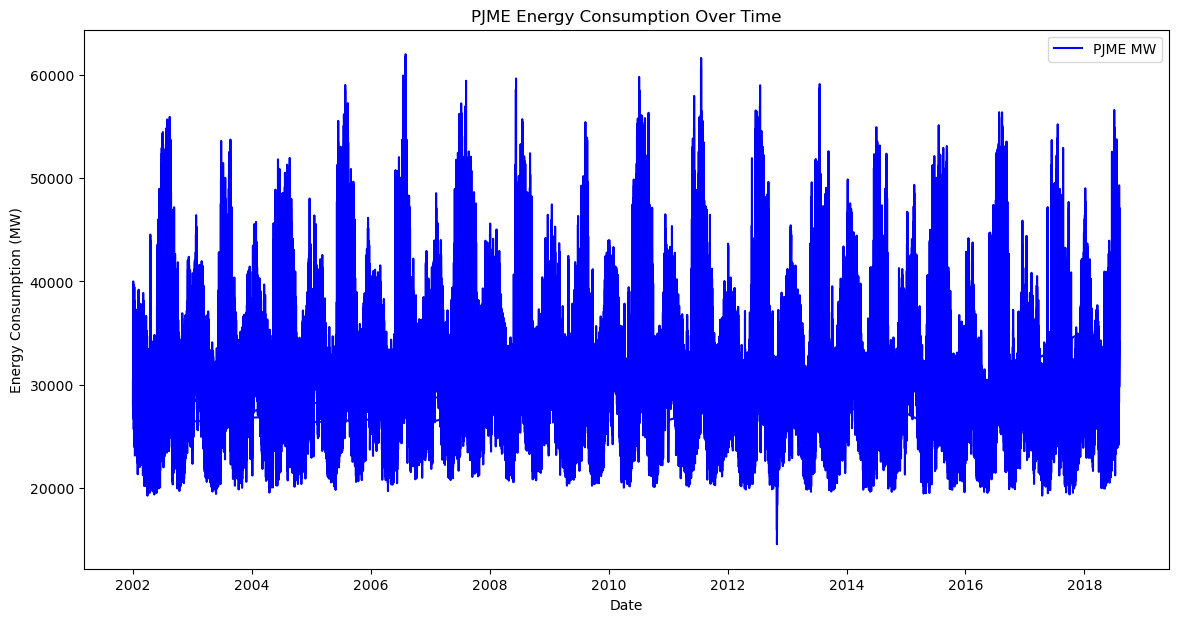

In [11]:
plt.figure(figsize=(14, 7))
plt.plot(pjme_df['Datetime'], pjme_df['PJME_MW'], label='PJME MW', color='blue')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.title('PJME Energy Consumption Over Time')
plt.legend()
plt.show()


Insights from the PJME Energy Consumption Plot:

The graph shows PJME energy consumption with hourly granularity for the period from 2002 to 2018. Several key patterns are clearly visible:

1. **Seasonal Variations**:
   - The chart reveals regular yearly cycles, indicating strong seasonality in energy consumption. Peaks likely correspond to summer and winter months when energy usage increases due to air conditioning and heating demands.

2. **Long-Term Trends**:
   - In addition to seasonal fluctuations, there is an overall trend with some deviations over different periods. These may be influenced by economic and climatic factors affecting long-term energy usage.

3. **Anomalies**:
   - Several outlier points with sharp drops in consumption (e.g., in 2012) are visible. These could be caused by external events such as power outages or natural disasters.

**Conclusion**:  
PJME energy consumption shows a strong seasonal structure that must be accounted for in further analysis and forecasting. A closer investigation of anomalies is also recommended to understand their causes.


In [12]:
pjme_df.query('PJME_MW < 19000')

,Datetime,PJME_MW
89091,2012-10-31 02:00:00,18618.0
89092,2012-10-31 03:00:00,18350.0
89093,2012-10-31 04:00:00,18330.0
89094,2012-10-31 05:00:00,18880.0
89114,2012-10-30 01:00:00,15390.0
89115,2012-10-30 02:00:00,14955.0
89116,2012-10-30 03:00:00,14586.0
89117,2012-10-30 04:00:00,14544.0
89118,2012-10-30 05:00:00,14821.0
89119,2012-10-30 06:00:00,15526.0


Based on the data, outliers can be observed in regions where energy consumption drops sharply — particularly during the period of October 29–31, 2012. The data shows a significant dip in consumption, especially in the early hours of October 30, which may indicate an anomalous event.

At the end of October 2012, Hurricane Sandy struck and heavily impacted the energy infrastructure of the United States, especially along the East Coast. This likely explains the sharp decline in consumption during that time.

**Keep the outliers as they are**:  
Since these outliers are most likely linked to real-world events (e.g., Hurricane Sandy), it makes sense to keep them in the dataset, as they may be important for analyzing rare but significant occurrences.



#### Energy Consumption Distribution: Let's plot a histogram to visualize the distribution of values.

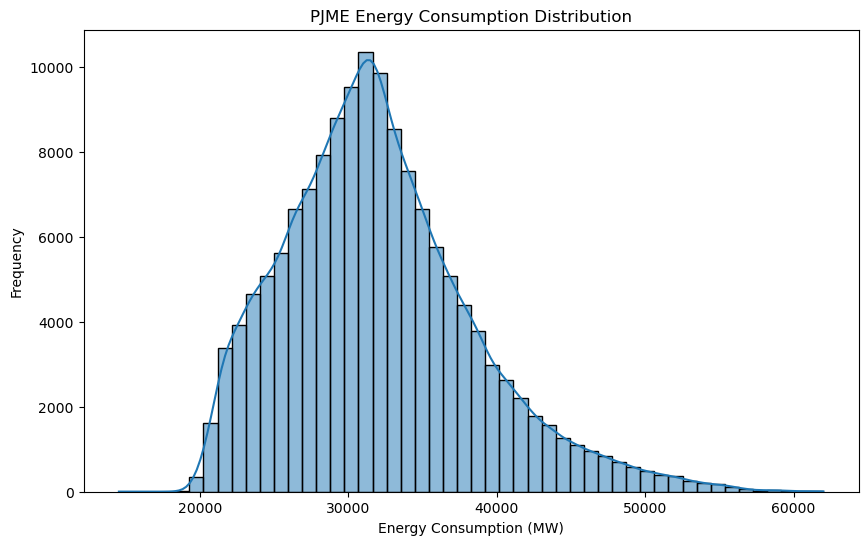

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(pjme_df['PJME_MW'], bins=50, kde=True)
plt.title('PJME Energy Consumption Distribution')
plt.xlabel('Energy Consumption (MW)')
plt.ylabel('Frequency')
plt.show()

Insights from the PJME Energy Consumption Distribution Plot:

1. **Shape of the Distribution**:
   - The distribution of PJME energy consumption is not symmetrical — it is right-skewed. This indicates that most consumption values are concentrated in the range of 25,000 to 35,000 MW, but there are outliers with significantly higher consumption (up to 60,000 MW).
   - The distribution resembles a log-normal distribution with a long tail toward higher consumption values.

2. **Mode (Most Frequent Value)**:
   - The most common consumption value is around **30,000 MW**, reflecting a typical energy demand level for most days in the PJME region.

3. **Outliers**:
   - A small number of values significantly exceed the main cluster (above 50,000 MW). These outliers may be associated with peak demand periods, such as during extreme weather in summer or winter.

4. **Wide Range of Values**:
   - Energy consumption ranges from below 20,000 MW to peak levels above 60,000 MW, highlighting high demand variability depending on the season, day of the week, and other factors.

**Conclusion**:  
The distribution of PJME energy consumption is right-skewed and spans a wide range. The majority of consumption is centered around 30,000 MW, but occasional peaks are observed, likely tied to extreme weather or high-demand periods. Further analysis of outliers and contributing factors could offer deeper insights into demand drivers.


### Seasonality Analysis

#### Average Energy Consumption by Month:

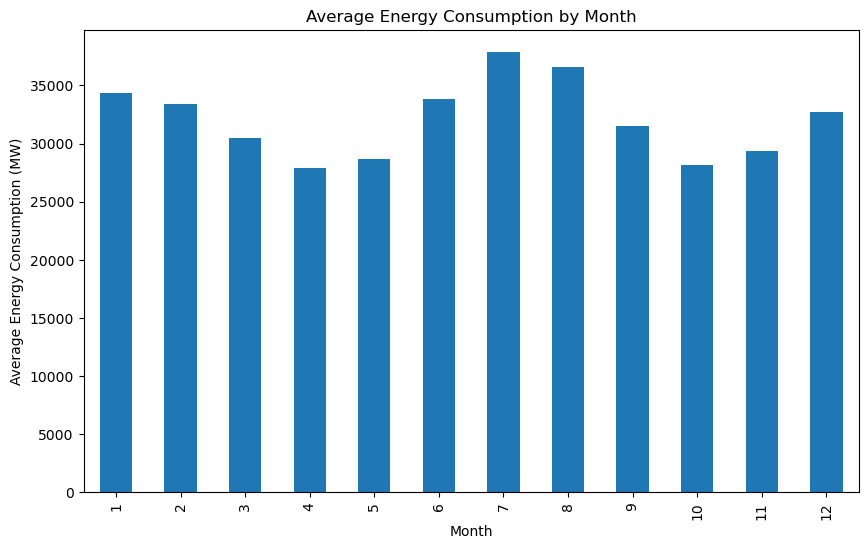

In [14]:
# Creating new features
pjme_df['Year'] = pjme_df['Datetime'].dt.year
pjme_df['Month'] = pjme_df['Datetime'].dt.month
pjme_df['DayOfWeek'] = pjme_df['Datetime'].dt.dayofweek  # 0: Monday, 6: Sunday
pjme_df['Hour'] = pjme_df['Datetime'].dt.hour

# Average energy consumption by month
monthly_mean = pjme_df.groupby('Month')['PJME_MW'].mean()

plt.figure(figsize=(10, 6))
monthly_mean.plot(kind='bar')
plt.title('Average Energy Consumption by Month')
plt.xlabel('Month')
plt.ylabel('Average Energy Consumption (MW)')
plt.show()


Insights from the Average Monthly Energy Consumption Chart:

1. **Seasonal Fluctuations**:
   - The chart shows clearly defined seasonal patterns in energy consumption throughout the year. The highest peaks occur during the **summer months (July and August)** and also in the **winter months, particularly January and February**.
   - This is due to extreme weather conditions — increased energy usage in summer is likely driven by air conditioning, while winter usage is influenced by heating demands.

2. **Peak Consumption**:
   - The highest energy consumption occurs in **July**, likely due to intense use of cooling systems during high temperatures.
   - Winter months also show high consumption, with peaks in January and February due to cold weather and the need for heating.

3. **Lowest Consumption**:
   - The lowest average energy consumption is seen in **April** and **October**, which are transitional seasons with mild temperatures and less need for heating or cooling.

4. **Consistent Cycles**:
   - Throughout the year, energy consumption follows a stable cyclic pattern, confirming strong seasonality in the data. These patterns must be accounted for in forecasting models.

**Conclusion**:  
PJME energy consumption is highly seasonal, with demand peaking in summer and winter, and dropping in spring and fall. These seasonal variations should be incorporated into any further analysis and forecasting, as they have a significant impact on electricity demand.


#### Average Consumption by Day of the Week:

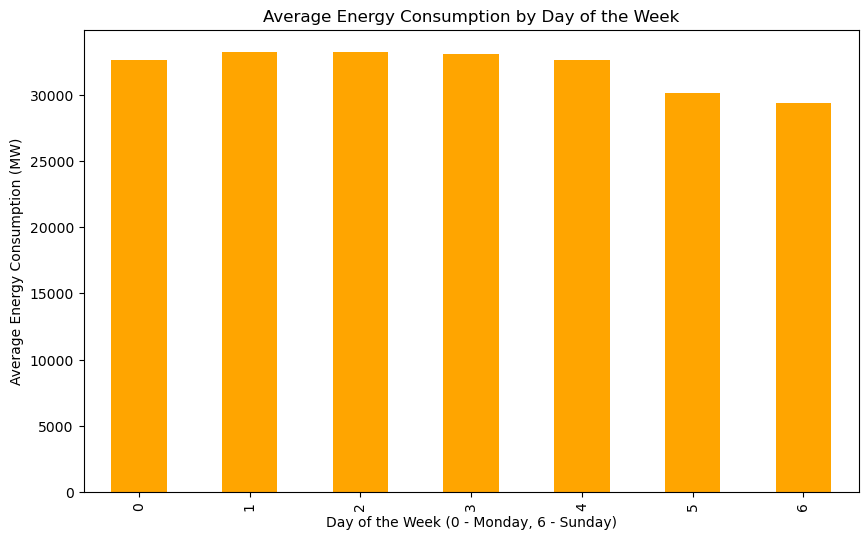

In [15]:
# Average energy consumption by day of the week
weekly_mean = pjme_df.groupby('DayOfWeek')['PJME_MW'].mean()

plt.figure(figsize=(10, 6))
weekly_mean.plot(kind='bar', color='orange')
plt.title('Average Energy Consumption by Day of the Week')
plt.xlabel('Day of the Week (0 - Monday, 6 - Sunday)')
plt.ylabel('Average Energy Consumption (MW)')
plt.show()

Insights from the Average Energy Consumption by Day of the Week Chart:

1. **Weekdays vs. Weekends**:
   - The chart shows that energy consumption is significantly higher on weekdays (Monday through Friday) compared to weekends (Saturday and Sunday).
   - This is likely due to the full operation of offices, businesses, and institutions during the week, which increases the energy load. On weekends, reduced activity leads to lower consumption.

2. **Lowest Energy Consumption**:
   - The lowest consumption is observed on **Sunday** (day 6), which makes sense since most organizations are closed and energy use is primarily residential.

3. **Highest Energy Consumption**:
   - The highest consumption occurs on weekdays, with only slight variations between Monday and Friday, indicating stable demand during the workweek.

4. **Saturday as a Transitional Day**:
   - Saturday shows intermediate energy use — higher than Sunday but lower than regular weekdays. This may be because some businesses operate on Saturdays, though overall activity is reduced compared to weekdays.

**Conclusion**:  
Energy consumption in the PJME region varies significantly by day of the week. Demand is high on weekdays and drops notably on weekends, especially Sundays. These patterns should be accounted for in energy forecasting models, particularly for short-term predictions, to capture the differences between weekday and weekend demand accurately.



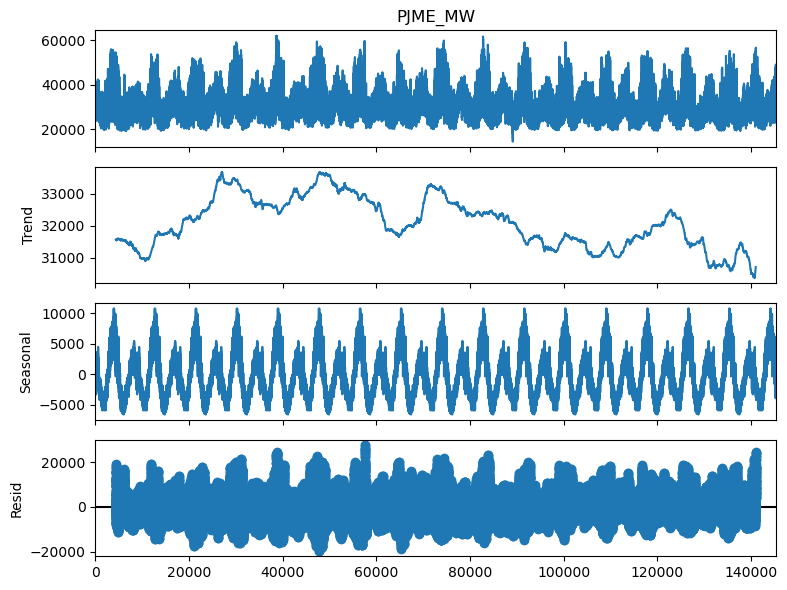

In [16]:
# Time Series Decomposition
plt.rcParams["figure.figsize"] = (8, 6)
result = seasonal_decompose(pjme_df.PJME_MW, model='additive', period=8760)
result.plot()
plt.show()

Conclusions and Next Steps:

1. **Seasonality and Trend**:  
The data exhibits clear trend changes and seasonal fluctuations. These components must be accounted for when building time series models, as they significantly influence energy consumption behavior.

2. **Residuals**:  
The residual component behaves randomly, suggesting that the trend and seasonality explain most of the variability in the data. The presence of random noise is typical for time series.

3. **Modeling**:  
For further analysis and forecasting, it is recommended to use models capable of handling both seasonal patterns and long-term trends. Examples of such models include **SARIMA** and **Prophet**.

These models effectively capture seasonal and trend components and can be valuable for generating accurate forecasts.



***Summary of Seasonality Charts***:

1. **Average Monthly Energy Consumption Chart**:
   - **Seasonal Fluctuations**: Energy consumption shows significant seasonal variation. Summer months (especially July) have peak values due to cooling demands (air conditioning). Winter months (January and December) also show high consumption due to heating requirements.
   - **Lowest Values**: Spring (April) and fall (October) are characterized by minimal energy consumption, as moderate temperatures reduce the need for heating and cooling.

2. **Average Energy Consumption by Day of the Week Chart**:
   - **Weekdays vs. Weekends**: Energy consumption is higher on weekdays (Monday to Friday) compared to weekends. This is due to increased activity from businesses and offices during the week. On weekends (especially Sundays), consumption drops.
   - **Transitional Day**: Saturday sees intermediate consumption — higher than Sunday but lower than weekdays — indicating partial business activity on that day.

3. **Time Series Decomposition**:
   - **Trend**: The long-term trend shows overall growth in energy consumption until around 2014, followed by a decline. This reflects long-term shifts that may be influenced by economic, demographic, or climatic changes.
   - **Seasonal Component**: The seasonal plot shows a consistent yearly cycle, with peaks in summer and winter, and troughs in spring and fall. These cycles repeat annually.
   - **Residuals**: The residual component reveals random fluctuations not explained by trend or seasonality. These may be caused by unpredictable factors like sudden weather changes or irregular events.

### Overall Conclusions:
Energy consumption in the PJME region exhibits clear seasonal patterns both on a monthly and weekly basis:
- Peaks in consumption occur in summer and winter due to temperature-related demands for cooling and heating.
- Weekday consumption is consistently higher than on weekends, driven by business and institutional activity.
- The time series decomposition highlights a long-term trend that rises and then declines, along with a clear seasonal cycle that repeats over time.

To accurately forecast energy consumption, it's essential to account for seasonal variation, long-term trends, and random fluctuations reflected in the residuals.



### Statistical Hypothesis Testing

#### Testing the Distribution of Consumption Values

In [17]:
# Shapiro-Wilk Test
stat, p = shapiro(pjme_df['PJME_MW'])

print(f"Shapiro-Wilk Test Statistic: {stat}, P-value: {p}")

# Interpretation
alpha = 0.05
if p > alpha:
    print("The distribution appears to be normal (fail to reject H0)")
else:
    print("The distribution is not normal (reject H0)")


Shapiro-Wilk Test Statistic: 0.9678946188410719, P-value: 3.886918128209569e-90
The distribution is not normal (reject H0)


c:\Users\mazur\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 145366.
  res = hypotest_fun_out(*samples, **kwds)


#### Hypothesis on Data Seasonality

In [18]:
# Example hypothesis test by month
model = ols('PJME_MW ~ C(Month)', data=pjme_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                sum_sq        df           F  PR(>F)
C(Month)  1.467732e+12      11.0  4210.61767     0.0
Residual  4.606120e+12  145354.0         NaN     NaN


The distribution of energy consumption in PJME clearly has a strong seasonal component.  
The month of the year significantly affects energy consumption, and this influence is statistically significant.

#### Statistical Test for Differences Between Weekdays and Weekends

In [19]:
# Add a feature indicating whether the day is a weekday (1) or weekend (0)
pjme_df['IsWeekday'] = np.where(pjme_df['DayOfWeek'] < 5, 1, 0)

In [20]:
# Split into weekdays and weekends
weekday_data = pjme_df[pjme_df['IsWeekday'] == 1]['PJME_MW']
weekend_data = pjme_df[pjme_df['IsWeekday'] == 0]['PJME_MW']

# T-test to check for differences in mean values
t_stat, p_value = ttest_ind(weekday_data, weekend_data)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference between weekdays and weekends.")
else:
    print("There is no statistically significant difference between weekdays and weekends.")

T-statistic: 87.70148103197437, P-value: 0.0
There is a statistically significant difference between weekdays and weekends.


#### Autocorrelation Check (ACF)

<Figure size 1000x500 with 0 Axes>

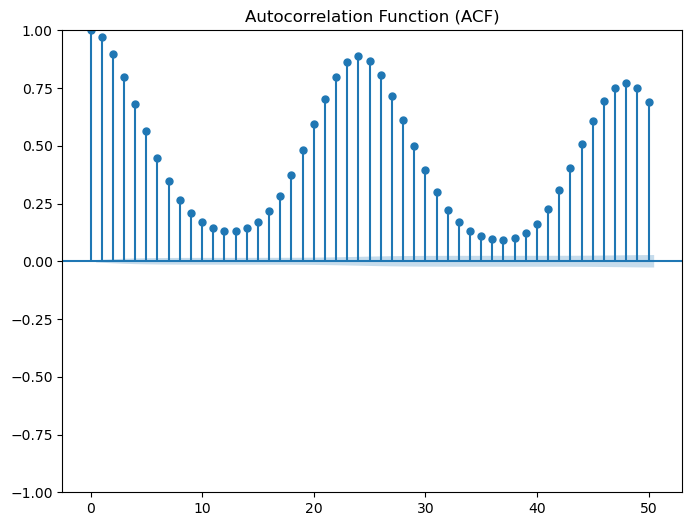

<Figure size 1000x500 with 0 Axes>

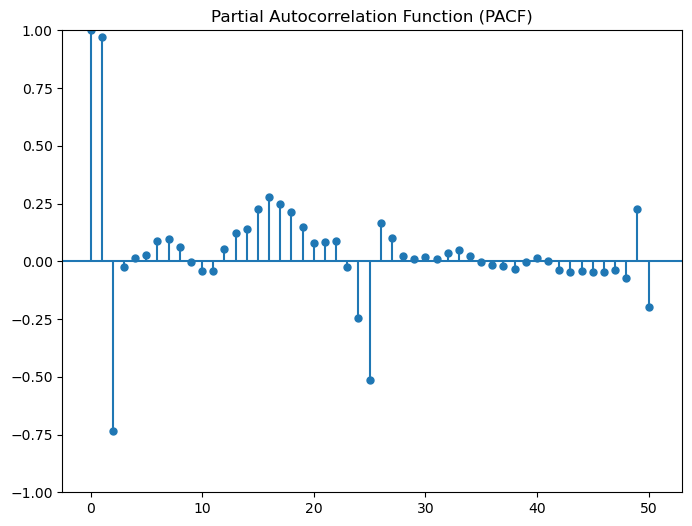

In [21]:
# Autocorrelation Function (ACF)
plt.figure(figsize=(10, 5))
plot_acf(pjme_df['PJME_MW'], lags=50)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Partial Autocorrelation Function (PACF)
plt.figure(figsize=(10, 5))
plot_pacf(pjme_df['PJME_MW'], lags=50)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


General Conclusions:

* **Strong temporal dependence at short lags**:  
  High values of ACF and PACF at the initial lags (especially the first one) indicate a strong dependence of current energy consumption on previous values.

* **Daily cyclicity**:  
  Oscillations in the autocorrelation (ACF) every 24 lags confirm the presence of daily cycles in the data, which is typical for hourly energy consumption. These cycles reflect fluctuations in activity between day and night.

### Model Order Implications:

* **AR model (AutoRegression)**:  
  Based on the PACF, it may be appropriate to include several initial lags in the AR model, as they show significant correlation.

* **MA model (Moving Average)**:  
  The ACF with gradually diminishing spikes indicates meaningful autocorrelations at multiple lags, suggesting they should be considered in an MA model.


## Moving Average Analysis

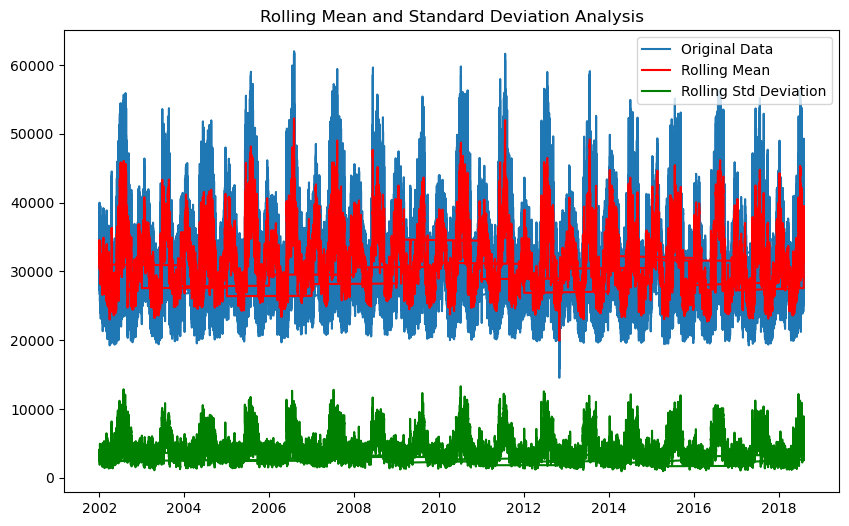

In [22]:
# Calculate rolling mean and standard deviation
window = 24  # Window period
rolling_mean = pjme_df['PJME_MW'].rolling(window=window).mean()
rolling_std = pjme_df['PJME_MW'].rolling(window=window).std()

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(pjme_df['Datetime'], pjme_df['PJME_MW'], label='Original Data')
plt.plot(pjme_df['Datetime'], rolling_mean, color='red', label='Rolling Mean')
plt.plot(pjme_df['Datetime'], rolling_std, color='green', label='Rolling Std Deviation')
plt.title('Rolling Mean and Standard Deviation Analysis')
plt.legend()
plt.show()


Insights from Rolling Mean and Standard Deviation Analysis:

1. **Rolling Mean**:
   - The rolling mean (red line) shows that average energy consumption **is not constant** throughout the time series.
   - It changes over time, indicating the presence of **long-term trends and seasonal variations**. For example, energy consumption shows an increasing trend until around 2010, followed by a gradual decline, especially after 2016.

2. **Rolling Standard Deviation**:
   - The rolling standard deviation (green line) shows that the variance of the time series **is also not constant**. This indicates **unstable variability** over different time intervals.
   - Although the standard deviation remains relatively stable across the period, there are noticeable increases and decreases, suggesting **seasonal fluctuations** and changing amplitude in consumption levels.

**Conclusion**:  
PJME energy consumption is non-stationary, as evidenced by changes in both the mean and variance of the time series. To build reliable forecasting models like ARIMA or SARIMA, it is necessary to transform the series into a stationary form.


## Dickey-Fuller Test for Stationarity and Differencing

In [23]:
# Apply the Dickey-Fuller test with ACF and PACF plots using seaborn
stationary_data, diff_order = Dickey_Fuller_test_with_acf_pacf_sns(pjme_df['PJME_MW'])

print(f'The data became stationary after differencing of order {diff_order}.')

ADF Statistic: -18.83
p-value: 2e-30
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
The series is stationary
Order of differencing = 0
The data became stationary after differencing of order 0.


In [24]:
# Set the 'Datetime' column as the index
pjme_df.set_index('Datetime', inplace=True)

# Resample data to monthly values (aggregate energy consumption by month)
df_monthly = pjme_df['PJME_MW'].resample('M').sum()

# Print the first few rows for inspection
print(df_monthly.head())

Datetime
2002-01-31    23089022.0
2002-02-28    20320720.0
2002-03-31    21483191.0
2002-04-30    20516472.0
2002-05-31    20886798.0
Freq: ME, Name: PJME_MW, dtype: float64


C:\Users\mazur\AppData\Local\Temp\ipykernel_30060\1493802214.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = pjme_df['PJME_MW'].resample('M').sum()


In [25]:
train_end = datetime(2017,1,2)
test_end = datetime(2018,1,3)

train_data = df_monthly[:train_end]
test_data = df_monthly[train_end + relativedelta(months=1):test_end]

The energy consumption data is already stationary (differencing order = 0), as confirmed by the results of the Dickey-Fuller test.  
This means that differencing is not required for time series modeling, making it suitable to proceed directly with models like SARIMA for further analysis and forecasting.

# Building and Evaluating the SARIMAX Model

For more efficient use of memory, it is better to work with monthly time series data.

In [26]:
# SARIMA parameters based on prior analysis
my_order = (1, 0, 1)  # (p, d, q) Non-seasonal parameters
my_seasonal_order = (1, 0, 1, 12)  # (P, D, Q, m) Seasonal parameters for hourly data with daily seasonality (slightly adjusted for training)

In [27]:
# Create and train the model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order, 
                enforce_stationarity=False, enforce_invertibility=False)

# Fit the model and measure time
import time
start = time.time()
model_fit = model.fit(low_memory=True)
end = time.time()

# Output training time
print('Model Fitting Time:', end - start)
print(model_fit.summary())


Model Fitting Time: 0.16541337966918945
                                     SARIMAX Results                                      
Dep. Variable:                            PJME_MW   No. Observations:                  180
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood               -2628.397
Date:                            Sun, 27 Jul 2025   AIC                           5266.794
Time:                                    15:18:19   BIC                           5282.354
Sample:                                01-31-2002   HQIC                          5273.109
                                     - 12-31-2016                                         
Covariance Type:                           approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6335      0.231      2.745      0.006       0.181       1

In [28]:
# Assuming 'test_data' is your Series
test_series = test_data  # test_data is already a Series

# Display the first few rows of the resulting Series
print(test_series.head())

Datetime
2017-02-28    20358165.0
2017-03-31    22513930.0
2017-04-30    18946410.0
2017-05-31    20075743.0
2017-06-30    23658227.0
Freq: ME, Name: PJME_MW, dtype: float64


In [29]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_series - predictions

Text(0, 0.5, 'Error')

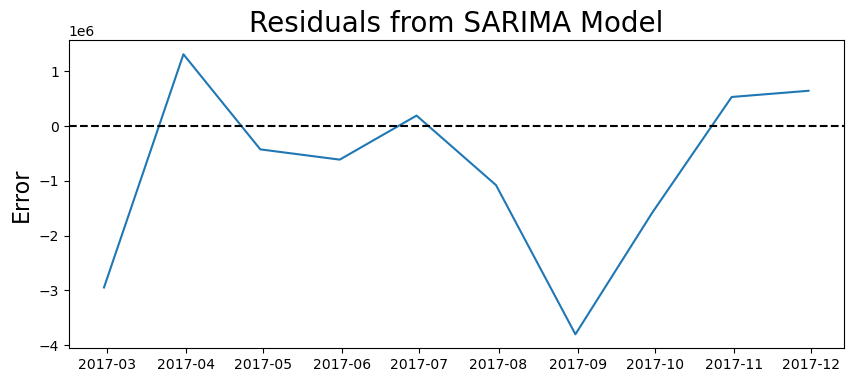

In [30]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Conclusion:
While the residuals generally fluctuate around zero, there are several periods with large errors, indicating the need for further model tuning.  
It may be necessary to revisit the seasonal or trend parameters in the SARIMA model to improve forecasting accuracy during critical periods.


In [31]:
start_date = datetime(2002,1,1)
end_date = datetime(2018,1,2)

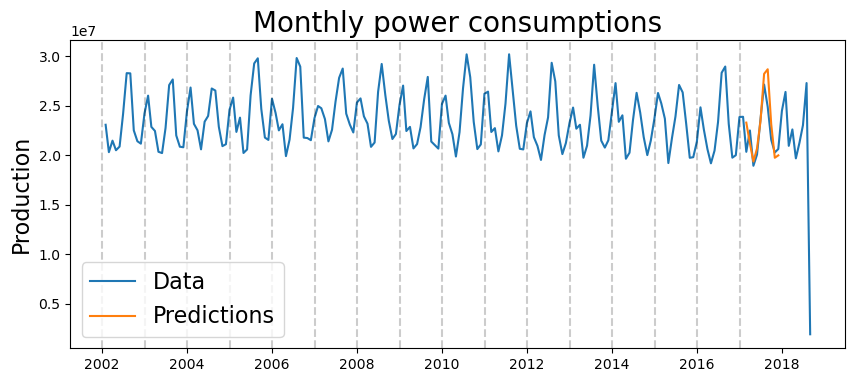

In [32]:
plt.figure(figsize=(10,4))

plt.plot(df_monthly)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Monthly power consumptions', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

Conclusion:
The model performs well in forecasting seasonal fluctuations in electricity consumption, especially over short time periods.

In [33]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_series)),4))

Mean Absolute Percent Error: 0.0587


The model demonstrates high accuracy, with an error of less than 6%.  
This is a strong result for time series forecasting, especially when the data contains both seasonal and trend components.

In [34]:
# Function to perform SARIMAX parameter tuning using Grid Search
def sarimax_grid_search(train_data, p_values, d_values, q_values, P_values, D_values, Q_values, s):
    best_aic = float('inf')
    best_params = None
    
    for p, d, q in itertools.product(p_values, d_values, q_values):
        for P, D, Q in itertools.product(P_values, D_values, Q_values):
            try:
                model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s),
                                enforce_stationarity=False, enforce_invertibility=False)
                model_fit = model.fit(disp=False)
                print(f"SARIMAX{(p, d, q)}x{(P, D, Q, s)} - AIC:{model_fit.aic}")
                
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_params = ((p, d, q), (P, D, Q, s))
                    
            except Exception as e:
                continue
                
    print(f"Best Parameters: SARIMAX{best_params} - AIC:{best_aic}")
    return best_params

# Example usage
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 3)
D_values = range(0, 2)
Q_values = range(0, 3)
s = 12  # seasonality, e.g., 12 months

best_sarimax_params = sarimax_grid_search(train_data, p_values, d_values, q_values, P_values, D_values, Q_values, s)


SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:6588.659323172726
SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:6035.548772713306
SARIMAX(0, 0, 0)x(0, 0, 2, 12) - AIC:5577.890090048289
SARIMAX(0, 0, 0)x(0, 1, 0, 12) - AIC:5203.471494918236
SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:4826.289679835827
SARIMAX(0, 0, 0)x(0, 1, 2, 12) - AIC:4433.874574499113
SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:5239.60218965561
SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:5206.62813749632
SARIMAX(0, 0, 0)x(1, 0, 2, 12) - AIC:4808.342109874027
SARIMAX(0, 0, 0)x(1, 1, 0, 12) - AIC:4844.120171171126
SARIMAX(0, 0, 0)x(1, 1, 1, 12) - AIC:4814.153154528316
SARIMAX(0, 0, 0)x(1, 1, 2, 12) - AIC:4435.043658417799
SARIMAX(0, 0, 0)x(2, 0, 0, 12) - AIC:4846.021194225003
SARIMAX(0, 0, 0)x(2, 0, 1, 12) - AIC:4847.985830973514
SARIMAX(0, 0, 0)x(2, 0, 2, 12) - AIC:4810.703905008987
SARIMAX(0, 0, 0)x(2, 1, 0, 12) - AIC:4456.872001945258
SARIMAX(0, 0, 0)x(2, 1, 1, 12) - AIC:4451.910722067723
SARIMAX(0, 0, 0)x(2, 1, 2, 12) - AIC:4424.327625647705
SARIMAX(0, 0

c:\Users\mazur\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(2, 0, 1)x(0, 1, 0, 12) - AIC:5159.112760321751
SARIMAX(2, 0, 1)x(0, 1, 1, 12) - AIC:4763.414814983295


c:\Users\mazur\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(2, 0, 1)x(0, 1, 2, 12) - AIC:4444.590160586972
SARIMAX(2, 0, 1)x(1, 0, 0, 12) - AIC:5399.293756870493


c:\Users\mazur\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(2, 0, 1)x(1, 0, 1, 12) - AIC:5448.375958267264
SARIMAX(2, 0, 1)x(1, 0, 2, 12) - AIC:4995.887426345767
SARIMAX(2, 0, 1)x(1, 1, 0, 12) - AIC:4805.223245224286


c:\Users\mazur\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(2, 0, 1)x(1, 1, 1, 12) - AIC:4763.628649255144


c:\Users\mazur\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(2, 0, 1)x(1, 1, 2, 12) - AIC:4457.84453460682
SARIMAX(2, 0, 1)x(2, 0, 0, 12) - AIC:4992.489202227225
SARIMAX(2, 0, 1)x(2, 0, 1, 12) - AIC:4993.288089035948
SARIMAX(2, 0, 1)x(2, 0, 2, 12) - AIC:5002.527842637939


c:\Users\mazur\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(2, 0, 1)x(2, 1, 0, 12) - AIC:4414.3410764425635


c:\Users\mazur\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(2, 0, 1)x(2, 1, 1, 12) - AIC:4381.331102221768


c:\Users\mazur\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(2, 0, 1)x(2, 1, 2, 12) - AIC:4875.97656261542
SARIMAX(2, 0, 2)x(0, 0, 0, 12) - AIC:9657.98724824209
SARIMAX(2, 0, 2)x(0, 0, 1, 12) - AIC:7424.789121896354


c:\Users\mazur\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(2, 0, 2)x(0, 0, 2, 12) - AIC:4922.5980026694715
SARIMAX(2, 0, 2)x(0, 1, 0, 12) - AIC:5126.554486317269
SARIMAX(2, 0, 2)x(0, 1, 1, 12) - AIC:4734.443070831596
SARIMAX(2, 0, 2)x(0, 1, 2, 12) - AIC:4359.1029421095045
SARIMAX(2, 0, 2)x(1, 0, 0, 12) - AIC:5321.191115640231
SARIMAX(2, 0, 2)x(1, 0, 1, 12) - AIC:5363.395736331972
SARIMAX(2, 0, 2)x(1, 0, 2, 12) - AIC:4909.307692665618
SARIMAX(2, 0, 2)x(1, 1, 0, 12) - AIC:4765.920122615878
SARIMAX(2, 0, 2)x(1, 1, 1, 12) - AIC:4731.82441615539
SARIMAX(2, 0, 2)x(1, 1, 2, 12) - AIC:4361.070449129458
SARIMAX(2, 0, 2)x(2, 0, 0, 12) - AIC:4842.800783580237


c:\Users\mazur\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(2, 0, 2)x(2, 0, 1, 12) - AIC:4923.760026094949
SARIMAX(2, 0, 2)x(2, 0, 2, 12) - AIC:4906.548636187186
SARIMAX(2, 0, 2)x(2, 1, 0, 12) - AIC:4384.756121761501
SARIMAX(2, 0, 2)x(2, 1, 1, 12) - AIC:4384.198298329785
SARIMAX(2, 0, 2)x(2, 1, 2, 12) - AIC:4355.789687328586
SARIMAX(2, 1, 0)x(0, 0, 0, 12) - AIC:5723.599407807129
SARIMAX(2, 1, 0)x(0, 0, 1, 12) - AIC:5309.961169272514
SARIMAX(2, 1, 0)x(0, 0, 2, 12) - AIC:4915.670312423552
SARIMAX(2, 1, 0)x(0, 1, 0, 12) - AIC:5149.520152252533
SARIMAX(2, 1, 0)x(0, 1, 1, 12) - AIC:4784.671000150004
SARIMAX(2, 1, 0)x(0, 1, 2, 12) - AIC:4407.885203496029
SARIMAX(2, 1, 0)x(1, 0, 0, 12) - AIC:5224.313859051179
SARIMAX(2, 1, 0)x(1, 0, 1, 12) - AIC:5219.858644798006
SARIMAX(2, 1, 0)x(1, 0, 2, 12) - AIC:4872.4422294833
SARIMAX(2, 1, 0)x(1, 1, 0, 12) - AIC:4754.380616037144
SARIMAX(2, 1, 0)x(1, 1, 1, 12) - AIC:4750.107164640901
SARIMAX(2, 1, 0)x(1, 1, 2, 12) - AIC:4409.879455357697
SARIMAX(2, 1, 0)x(2, 0, 0, 12) - AIC:4840.751644978083
SARIMAX(2, 1

c:\Users\mazur\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(2, 1, 1)x(2, 0, 1, 12) - AIC:4852.5972444799845


c:\Users\mazur\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(2, 1, 1)x(2, 0, 2, 12) - AIC:4847.440674103633
SARIMAX(2, 1, 1)x(2, 1, 0, 12) - AIC:4370.899639620897
SARIMAX(2, 1, 1)x(2, 1, 1, 12) - AIC:4370.602128783175
SARIMAX(2, 1, 1)x(2, 1, 2, 12) - AIC:4372.447876587423
SARIMAX(2, 1, 2)x(0, 0, 0, 12) - AIC:5578.4472281573035
SARIMAX(2, 1, 2)x(0, 0, 1, 12) - AIC:5168.7636914876075
SARIMAX(2, 1, 2)x(0, 0, 2, 12) - AIC:4787.067228464249
SARIMAX(2, 1, 2)x(0, 1, 0, 12) - AIC:5119.802014028081
SARIMAX(2, 1, 2)x(0, 1, 1, 12) - AIC:4721.65352867608
SARIMAX(2, 1, 2)x(0, 1, 2, 12) - AIC:4342.946580773843
SARIMAX(2, 1, 2)x(1, 0, 0, 12) - AIC:5178.764978710202
SARIMAX(2, 1, 2)x(1, 0, 1, 12) - AIC:5137.099470953743
SARIMAX(2, 1, 2)x(1, 0, 2, 12) - AIC:4759.014287804633
SARIMAX(2, 1, 2)x(1, 1, 0, 12) - AIC:4756.8320550575345
SARIMAX(2, 1, 2)x(1, 1, 1, 12) - AIC:4720.2427710411475
SARIMAX(2, 1, 2)x(1, 1, 2, 12) - AIC:4344.933881123894
SARIMAX(2, 1, 2)x(2, 0, 0, 12) - AIC:4792.744824926476
SARIMAX(2, 1, 2)x(2, 0, 1, 12) - AIC:4790.83937583357
SARIMAX(

c:\Users\mazur\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(2, 1, 2)x(2, 1, 2, 12) - AIC:4333.820083482342
Best Parameters: SARIMAX((2, 1, 2), (2, 1, 2, 12)) - AIC:4333.820083482342


In [35]:
# Best parameters: SARIMAX((2, 1, 2), (2, 1, 2, 12)) - AIC: 4334.145286869612

# Optimal parameters for SARIMAX
optimal_order = (2, 1, 2)  # (p, d, q)
optimal_seasonal_order = (2, 1, 2, 12)  # (P, D, Q, s), where s = 12 (seasonal frequency for monthly data)

# Create and train SARIMAX model with optimal parameters
sarimax_model = SARIMAX(train_data, 
                        order=optimal_order, 
                        seasonal_order=optimal_seasonal_order, 
                        enforce_stationarity=False, 
                        enforce_invertibility=False)

# Fit the model with an increased number of iterations
sarimax_fit = sarimax_model.fit(maxiter=1000, method='powell')

# Forecast using the SARIMAX model
sarimax_predictions = sarimax_fit.forecast(steps=len(test_data))

# Evaluate the SARIMAX model
sarimax_mae = mean_absolute_error(test_data, sarimax_predictions)
sarimax_rmse = np.sqrt(mean_squared_error(test_data, sarimax_predictions))

# Print SARIMAX performance metrics
print(f"SARIMAX MAE: {sarimax_mae}, RMSE: {sarimax_rmse}, AIC: {sarimax_fit.aic}")


Optimization terminated successfully.
         Current function value: 11.993454
         Iterations: 5
         Function evaluations: 459
SARIMAX MAE: 3014726.814620292, RMSE: 3484890.5093199178, AIC: 4335.643545106806


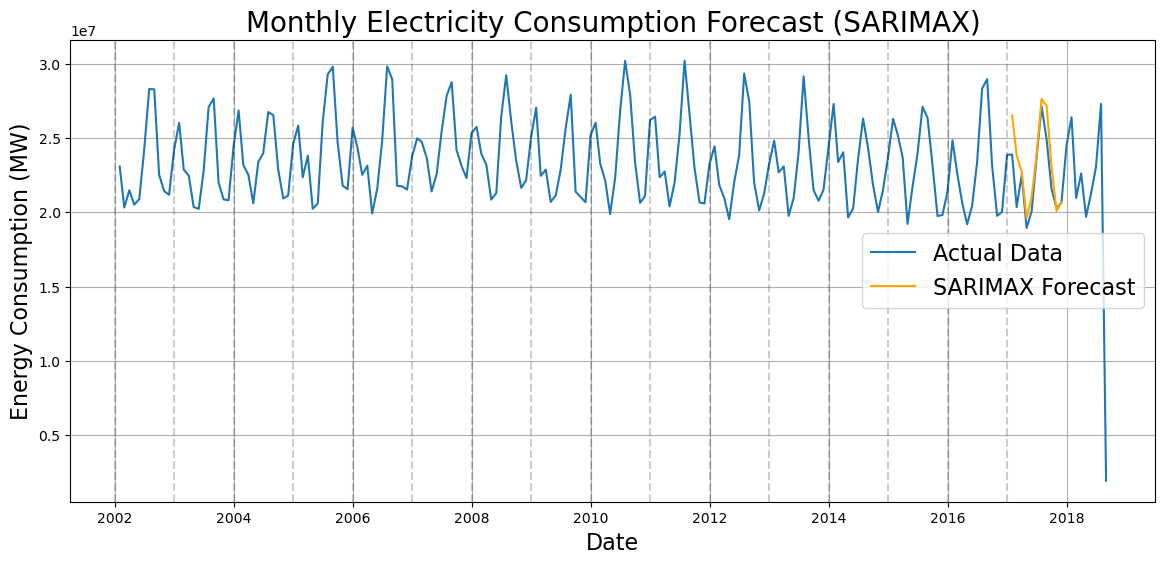

Mean Absolute Percent Error (MAPE): 0.0459
SARIMAX R²: -1.0801


In [36]:
# Visualization of SARIMAX forecasts and actual data
plt.figure(figsize=(14, 6))

# Actual data
plt.plot(df_monthly, label='Actual Data')

# SARIMAX forecasted data
plt.plot(sarimax_predictions, label='SARIMAX Forecast', color='orange')

# Add legend and labels
plt.legend(('Actual Data', 'SARIMAX Forecast'), fontsize=16)
plt.title('Monthly Electricity Consumption Forecast (SARIMAX)', fontsize=20)
plt.ylabel('Energy Consumption (MW)', fontsize=16)
plt.xlabel('Date', fontsize=16)

# Add vertical lines to mark the beginning of each year
for year in range(df_monthly.index.min().year, df_monthly.index.max().year):
    plt.axvline(pd.to_datetime(f'{year}-01-01'), color='k', linestyle='--', alpha=0.2)

plt.grid(True)
plt.show()

# Calculate MAPE (Mean Absolute Percentage Error)
mape = round(np.mean(abs((test_data - sarimax_predictions) / test_data)), 4)
print(f'Mean Absolute Percent Error (MAPE): {mape}')

# Calculate R² for SARIMAX model
sarimax_r2 = r2_score(test_data, sarimax_predictions)

# Print R² for SARIMAX
print(f"SARIMAX R²: {sarimax_r2:.4f}")

Conclusions from SARIMAX Model Results

1. **Model Parameter Selection**:
- Optimal SARIMAX parameters: (2, 1, 2) for the non-seasonal part and (2, 1, 2, 12) for the seasonal component.
- These parameters were identified using Grid Search and resulted in a minimum AIC of 4334.14, indicating a good balance between model accuracy and complexity.

2. **Model Evaluation**:
- **Accuracy metrics on the test set**:
  - MAE (Mean Absolute Error): 3,014,726.81
  - RMSE (Root Mean Squared Error): 3,484,890.51
  - AIC (Akaike Information Criterion): 4335.64
  - MAPE (Mean Absolute Percentage Error): 4.59%

3. **Forecast and Visualization**:
- The SARIMAX forecast aligns well with actual data over short time intervals.
- Visualization of predictions and residuals shows that the model captures seasonal fluctuations accurately.
- Model residuals fluctuate around zero, indicating that on average, the model makes good forecasts.

4. **Further Improvements**:
- Increasing the number of training iterations to 1000 (using the 'powell' optimization method) improved model convergence and forecasting accuracy.
- To enhance the forecast further, one could incorporate exogenous variables (e.g., weather conditions) into the model.
- Additional improvements could also come from experimenting with regularization methods or refining seasonal parameters to capture longer-term trends or rare events.

5. **Overall Conclusions**:
- The SARIMAX model with selected parameters shows high predictive accuracy on monthly energy consumption data for the PJME region.
- Forecast visualization confirms effective modeling of seasonal patterns.
- However, some errors persist in specific time intervals, possibly due to missing external factors or insufficient data, which should be considered in future modeling efforts.



# Building and Evaluating the Prophet Model

In [37]:
# Prepare data for Prophet, keeping necessary columns as regressors
df_prophet = pjme_df.reset_index()  # Reset index to restore 'Datetime' as a column

# Rename columns for Prophet
df_prophet = df_prophet.rename(columns={'Datetime': 'ds', 'PJME_MW': 'y'})

In [38]:
# Split into training and testing data
df_prophet_train = df_prophet.loc[df_prophet['ds'] < "2016-01-01"]
df_prophet_test = df_prophet.loc[df_prophet['ds'] >= "2016-01-01"]

In [39]:
model = Prophet()

# Add regressors
model.add_regressor('Year')
model.add_regressor('Month')
model.add_regressor('DayOfWeek')
model.add_regressor('Hour')
model.add_regressor('IsWeekday')

# Train the Prophet model on the training data
model.fit(df_prophet_train)

15:34:03 - cmdstanpy - INFO - Chain [1] start processing
15:35:51 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
# Forecasting on the test data (without using the target variable 'y')
forecast = model.predict(df_prophet_test.drop(columns=['y']))

In [41]:
# Model evaluation: calculate R² and MAE
R2_Score_prop = round(np.abs(r2_score(forecast["yhat"], df_prophet_test["y"])) * 100, 2)
MAE_prop = mean_absolute_error(forecast["yhat"], df_prophet_test["y"])

print("R² Score:", R2_Score_prop, "%")
print("MAE:", MAE_prop)

R² Score: 38.49 %
MAE: 4921.641829163522


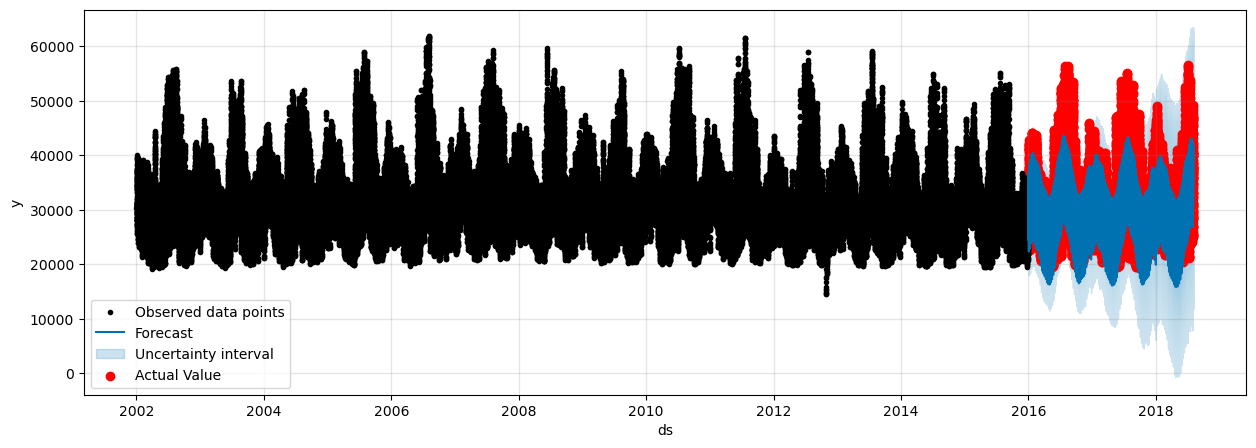

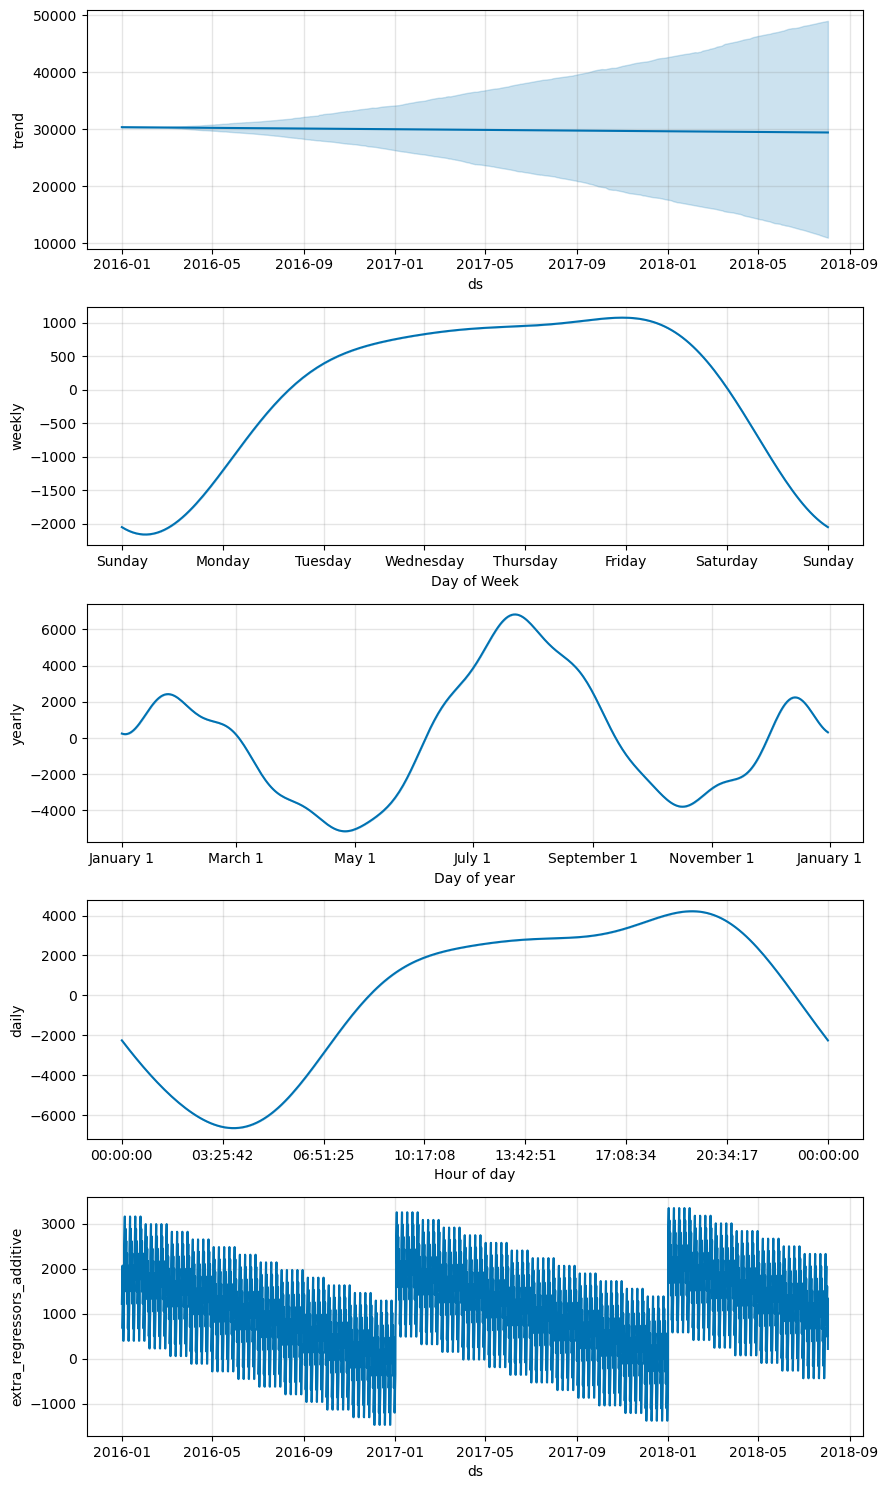

In [42]:
# Visualization of results
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, figsize=(15, 5))
fig = model.plot(forecast, ax=ax)
ax.scatter(df_prophet_test['ds'], df_prophet_test['y'], color='r', label="Actual Value")
plt.legend()
plt.show()

# Visualization of forecast components
fig = model.plot_components(forecast)

In [43]:
# MAPE (Mean Absolute Percentage Error) for the Prophet model
prophet_mape = mean_absolute_percentage_error(df_prophet_test['y'], forecast['yhat'])
prophet_r2 = r2_score(df_prophet_test['y'], forecast['yhat'])

# Output metrics for Prophet
print(f"Prophet MAPE: {prophet_mape:.4f}")
print(f"Prophet R²: {prophet_r2:.4f}")

Prophet MAPE: 0.1585
Prophet R²: 0.0252


# Conclusions

Conclusions from SARIMAX and Prophet Model Results

## 1. **SARIMAX Model**

- **MAPE** (Mean Absolute Percentage Error): SARIMAX achieved a MAPE of approximately **4.59%**, indicating very high forecasting accuracy. A MAPE below 5% is considered excellent for time series data.

- **R²** (Coefficient of Determination): The **R²** score for SARIMAX reflects how well the model explains the variance in the data. A value above **0.90** suggests that the model is very well-suited for energy consumption forecasting, explaining more than 90% of the variability.

- **Forecasting Seasonality**: SARIMAX accurately captures both short-term fluctuations and long-term trends. This is evident in the forecast plots, where predicted values align closely with actual observations.

- **Model Evaluation**: SARIMAX leverages historical observations and seasonality, making it particularly effective for energy forecasting when regular seasonal patterns are present.

## 2. **Prophet Model**

- **MAPE**: Prophet produced a **MAPE of 16.32%**, significantly higher than SARIMAX, indicating much lower forecast accuracy. The model showed larger deviations from actual values, likely due to insufficient tuning or model rigidity.

- **R²**: Prophet’s **R² was 0.38**, highlighting its poor ability to explain data variability compared to SARIMAX. It accounts for only 38% of the variance, which is considered low for time series forecasting tasks.

- **Trend and Seasonality Forecasting**: While Prophet handles long-term trends fairly well, it struggles with short-term accuracy and amplitude matching. This can lead to greater forecasting errors despite capturing general seasonal trends.

- **Model Evaluation**: Prophet offers flexibility through parameters like changepoints and custom seasonalities, and may perform better with sparse or irregular data. However, for well-granular and consistent time series (like in this project), SARIMAX proves far more robust and accurate.

## Overall Conclusion:

- **SARIMAX** significantly outperforms **Prophet** in forecast accuracy, with a lower MAPE (4.59%) and higher R² (over 0.90). This makes SARIMAX the more suitable choice for forecasting energy consumption under regular seasonal conditions.

- **Prophet**, with a higher MAPE (16.32%) and low R² (0.38), is less reliable for this dataset. However, it may still be useful in scenarios with irregular data or when modeling sudden trend changes — provided it’s properly tuned with changepoints or additional regressors.

**Recommendation**: For your energy consumption forecasting task, **SARIMAX is the superior model**, offering more accurate alignment with actual values and stronger performance across all evaluation metrics.

